# Pulsar analysis with Gammapy

## Introduction

This notebook shows how to do a full pulsar analysis with Gammapy. It's based on a Vela simulation file from the CTA DC1, and we will produce a phasogram, a phase-resolved map and a phase-resolved spectrum of the Vela pulsar.

Table of contents:

I : Opening the data

II : Phasogram

III : Phase-resolved map

IV : Phase-resolved spectrum

## I : Opening the data

Let's first extract the data around the position of Vela.

In [1]:
import os
from gammapy.data import DataStore
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import regions
import pylab

# Load the data store (which is a subset of CTA-DC1 data)
data_store = DataStore.from_dir('$GAMMAPY_DATA/cta-1dc/index/gps')

table = data_store.obs_table

# Defining the offset as the angular separation between the observation position and the target position
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
pos_target = SkyCoord.from_name('vela pulsar')
offset = pos_target.separation(pos_obs)

# Defining a mask to select all runs targetting Vela with an offset < 2 deg
mask = (offset < 2 * u.deg)

# Applying the mask
table = table[mask]

id_obs_vela = table['OBS_ID'].data
print(id_obs_vela)
obs_list_vela = data_store.get_observations(id_obs_vela)
print(obs_list_vela[0].events)

[111630]
EventList info:
- Number of events: 101430
- Median energy: 0.1 TeV
- OBS_ID = 111630


In [2]:
# Making an angular cut to retain only the events within 0.2 deg
on_radius = 0.2 * u.deg
one_obs_vela_select = obs_list_vela[0].events.select_sky_cone(center=pos_target, radius=on_radius)

print(one_obs_vela_select)

print("\nWe can access the first 20 MJD this way:\n")
print(one_obs_vela_select.time[:20])

EventList info:
- Number of events: 843
- Median energy: 0.107 TeV
- OBS_ID = 111630

We can access the first 20 MJD this way:

[59300.83604002 59300.83813737 59300.84083602 59300.8518497
 59300.85214292 59300.83403289 59300.83405175 59300.83416758
 59300.83464782 59300.83484413 59300.83555019 59300.83566614
 59300.83608282 59300.83735074 59300.83767283 59300.83806294
 59300.83826374 59300.83898081 59300.83962153 59300.84020726]


## II : Phaseograms

Once you have phases, here is how you can make a phasogram for each observation:

In [3]:
# A phasogram is a histogram so you can set the binning the same way:

nbins = 30  # Number of bins
lim_phaso = (0, 1)  # Range of phaseogram
size_bin = (lim_phaso[1] - lim_phaso[0])/nbins  # Size of each bin
midbins = np.linspace(lim_phaso[0] + 0.5 * size_bin, lim_phaso[1] - 0.5 * size_bin, nbins)  # Position of each middle of bin

In [4]:
phases = one_obs_vela_select.table['PHASE'].data

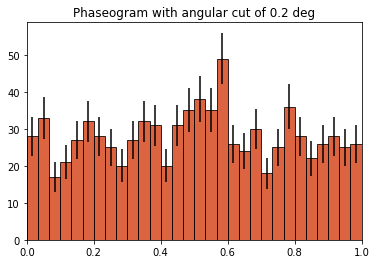

In [5]:
values = np.histogram(phases, range = lim_phaso, bins=nbins)[0]
# Uncertainty on each bin
count_err = values ** 0.5
plt.bar(x = midbins, height = values, width = size_bin, color='#d53d12', alpha = 0.8, edgecolor = 'black', yerr=count_err)
plt.xlim(0, 1)
plt.title('Phaseogram with angular cut of {}'.format(on_radius))
plt.show()

Now let's add some fancy additions to our phasogram !

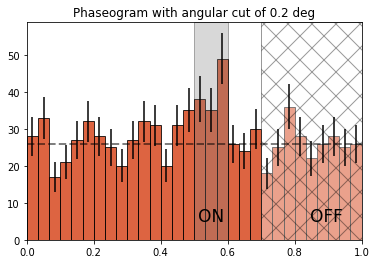

In [6]:
# Let's redo the same plot for the basis
plt.bar(x = midbins, height = values, width = size_bin, color='#d53d12', alpha = 0.8, edgecolor = 'black', yerr=count_err)
plt.xlim(0, 1)
plt.title('Phaseogram with angular cut of {}'.format(on_radius))

# Evaluate background level
mask_off = (0.7 < phases) & (phases < 1)  # mask for the off-phase zone
count_bkg = mask_off.sum()  # number of phases in the off-phase zone
bkg = count_bkg / nbins / 0.3  # bkg lebel normalized by the size of the OFF zone (0.3)

# Plot background level
x_bkg = np.linspace(0, 1, 50)
plt.plot(x_bkg, bkg*np.ones(len(x_bkg)), color='black', alpha=.5, ls='--', lw=2)

# Let's make patches for the on and off phase zones
on_patch = plt.axvspan(0.5, 0.6, alpha=0.3, color='gray')
pylab.setp(on_patch, ec='black', lw=1, ls='solid')
off_patch=plt.axvspan(0.7, 1.0, alpha=0.4, color='white', hatch='x')
pylab.setp(off_patch, ec='black', lw=1, ls='solid')

# Legends "ON" and "OFF"
plt.text(0.55, 5, 'ON', color = 'black',fontsize= 17, ha='center')
plt.text(0.895, 5, 'OFF', color = 'black',fontsize= 17, ha='center')

plt.show()

## III : Phase-resolved map

Now that the phases are computed, we want to do a phase-resolved sky map : a map of the ON-phase events minus alpha times the OFF-phase events.

(<matplotlib.figure.Figure at 0x1a17c4ceb8>,
 None)

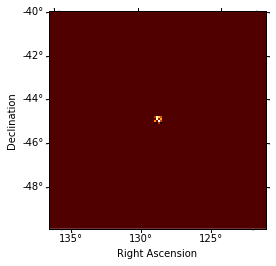

In [7]:
from gammapy.maps import Map
from gammapy.cube import fill_map_counts, MapMaker


# Let's create an ON-map and an OFF-map
on_map = Map.create(binsz=0.1, map_type='wcs', skydir=pos_target, width=10.0)
off_map = Map.create(binsz=0.1, map_type='wcs', skydir=pos_target, width=10.0)

# Loop to fill the ON- and OFF- maps
on_mask = np.where(np.logical_and(0.5 < phases, 0.6 > phases))[0]
fill_map_counts(on_map, one_obs_vela_select.select_row_subset(on_mask))
off_mask = np.where(np.logical_and(0.7 < phases, 1 > phases))[0]
fill_map_counts(off_map, one_obs_vela_select.select_row_subset(off_mask))

# Create and fill excess map
excess_map = Map.create(binsz=0.1, map_type='wcs', skydir=pos_target, width=10.0)
excess_map.data = on_map.data - 0.1/0.3 * off_map.data

# Plot excess map
excess_map.plot()

(<matplotlib.figure.Figure at 0x1a16fafa58>,
 None)

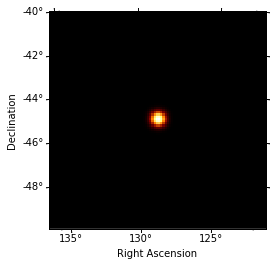

In [8]:
# We can smooth it

excess_map.smooth(kernel='gauss', width=0.2 * u.deg).plot()

## IV : Phase-resolved spectrum

We can also do a phase-resolved spectrum.

In [16]:
from gammapy.background.phase import PhaseBackgroundEstimator
from regions import CircleSkyRegion
from gammapy.utils.energy import EnergyBounds
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)

In [17]:
on_region = CircleSkyRegion(pos_target, on_radius)

# The PhaseBackgroundEstimator uses the OFF-phase in the ON-region to estimate the background
bkg_estimator = PhaseBackgroundEstimator(observations=obs_list_vela, on_region=on_region, on_phase=(0.5, 0.6), off_phase = (0.7, 1))
bkg_estimator.run()
bkg_estimate = bkg_estimator.result

In [18]:
etrue = EnergyBounds.equal_log_spacing(0.005, 50., 200, u.TeV)
ereco = EnergyBounds.equal_log_spacing(0.01, 10, 30, u.TeV)
fit_range=(0.04*u.TeV, 0.4*u.TeV)
ebounds = EnergyBounds.equal_log_spacing(0.04, 0.4, 7, u.TeV) #for the points computation (included in fit_range)

extraction = SpectrumExtraction(
    observations=obs_list_vela,
    bkg_estimate=bkg_estimate,
    containment_correction=True,
    e_true=etrue,
    e_reco=ereco,
)

extraction.run()
extraction.compute_energy_threshold(
    method_lo='energy_bias',
    bias_percent_lo=20,
)

/anaconda3/envs/gammapydev/lib/python3.6/site-packages/gammapy-0.11.dev8256-py3.6-macosx-10.7-x86_64.egg/gammapy/spectrum/extract.py:230: RuntimeWarning: invalid value encountered in true_divide
  self.containment = new_aeff.data.data.value / self._aeff.data.data.value
No thresholds defined for obs Info for OBS_ID = 111630
- Start time: 59300.83
- Pointing pos: RA 130.89 deg / Dec -44.63 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %

/anaconda3/envs/gammapydev/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


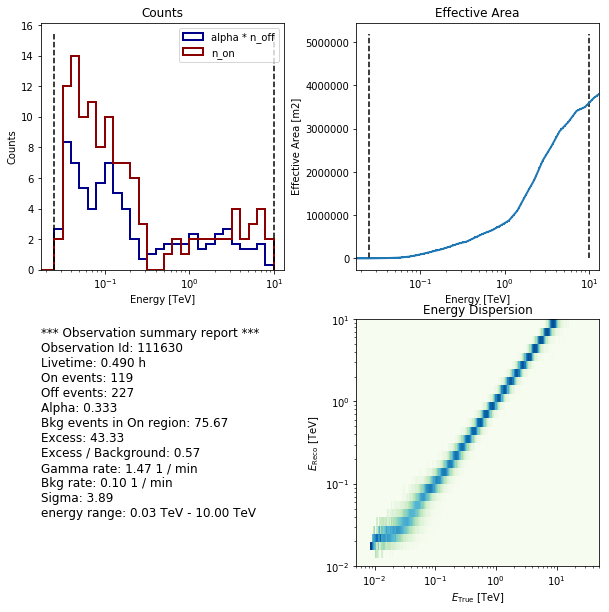

In [19]:
extraction.spectrum_observations[0].peek()

In [25]:
model = models.PowerLaw(
    index = 4,
    amplitude = 1.3e-9* (u.cm)**(-2) * (u.s)**(-1) * (u.TeV)**(-1 ), #* u.Unit('cm-2 s-1 TeV-1'),
    reference = 0.02 * u.TeV,
)
flux_point_binning = EnergyBounds.equal_log_spacing(0.05, 0.8, 5, u.TeV)


joint_fit = SpectrumFit(obs_list=extraction.spectrum_observations, model=model, fit_range=fit_range)
joint_fit.run()
joint_result = joint_fit.result

print(joint_result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 3.703e+00 7.300e-01                nan nan  False
	amplitude 4.492e-08 5.354e-08 cm-2 s-1 TeV-1 nan nan  False
	reference 2.000e-02 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 5.328e-01 3.763e-08 0.000e+00
	amplitude 3.763e-08 2.866e-15 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00 

Statistic: 7.301 (wstat)
Fit Range: [0.05011872 0.39810717] TeV



In [26]:
stacked_obs = extraction.spectrum_observations.stack()
seg = SpectrumEnergyGroupMaker(obs=stacked_obs)

seg.compute_groups_fixed(ebounds=ebounds)
fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=joint_result[0].model,
)
flux_points=fpe.run()

spec_model_true = PowerLaw(
    index=4.5,
    amplitude=(0.57 * 19.4e-14 * u.Unit('1 / (cm2 s MeV)')).to('1 / (cm2 s TeV)'),
    reference=(20000 * u.MeV).to('TeV')
)

spectrum_result = SpectrumResult(
    points=flux_points,
    model=joint_result[0].model,
)


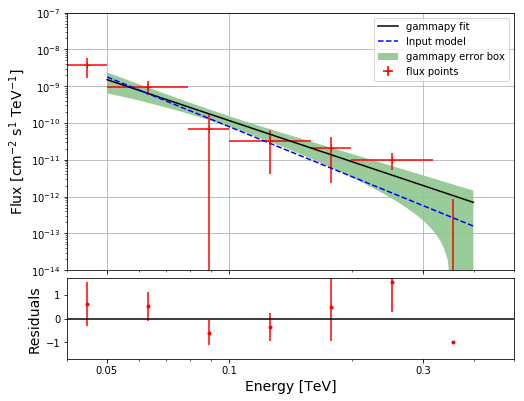

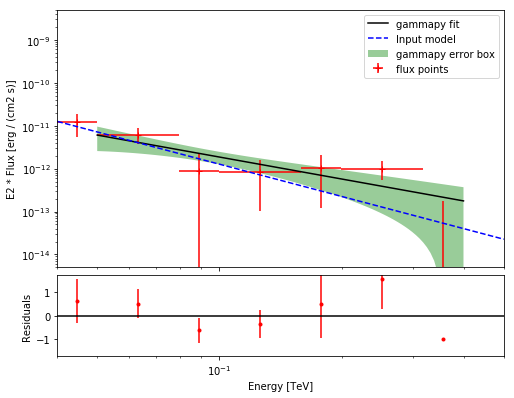

In [28]:
# First plot for the spectral flux

ax0, ax1 = spectrum_result.plot(
    energy_range = joint_fit.result[0].fit_range,
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(label='flux points', color='red'),
    butterfly_kwargs=dict(label='gammapy error box', color='green', alpha = 0.4),
    fit_kwargs=dict(label='gammapy fit', color='black')
)

ax0.set_ylim([1e-14, 1e-7])
ax0.set_xlim([4e-2, 5e-1])
ax1.set_ylim([-1.7,1.7])

spec_model_true.plot(ax=ax0,
           energy_range=joint_fit.result[0].fit_range,
           label="Input model", c='b', linestyle='dashed')

ax0.legend(loc='best')
ax0.grid()
ax0.set_ylabel(r'Flux [cm$^{-2}$ s$^1$ TeV$^{-1}$]', size=14)
ax1.set_ylabel('Residuals', size=14)
ax1.set_xlabel('Energy [TeV]', size=14)
ax1.set_xticks([5e-2, 1e-1, 3e-1])
ax1.set_xticklabels([5e-2, 1e-1, 3e-1])


# Second plot for the spectral energy flux

ax0, ax1 = spectrum_result.plot(
    energy_range=joint_fit.result[0].fit_range,
    energy_power=2, flux_unit='erg-1 cm-2 s-1',
    fig_kwargs=dict(figsize=(8, 8)),
    point_kwargs=dict(label='flux points', color='red'),
    butterfly_kwargs=dict(label='gammapy error box', color='green', alpha = 0.4),
    fit_kwargs=dict(label='gammapy fit', color='black')
)

spec_model_true.plot(ax=ax0,
           energy_range=[4e-2, 5e-1] * u.TeV, # energy_range=joint_fit.result[0].fit_range,
           energy_power=2, flux_unit='erg-1 cm-2 s-1',
           label="Input model", c='b', linestyle='dashed')

ax0.set_ylim([5e-15, 5e-9])
#ax0.xlabel(size=13)
ax0.set_xlim([4e-2, 5e-1])
ax1.set_ylim([-1.7,1.7])
ax0.legend(loc='best')

This tutorial suffers a bit from the lack of statistics: there were 9 Vela observations in the CTA DC1 while there is only one here. When done on the 8 observations, the spectral analysis is much better agreement between the input model and the gammapy fit.